In [1]:
import os
import requests
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 24*31)

In [2]:
db = sqlite3.connect('./weather.db')

# Select fields and stations usefull from modelling perspctive

### Load all fileds, print them with indices

In [3]:
data_format = []

with requests.get(r'https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/terminowe/synop/s_t_format.txt') as format_file:
    format_file.encoding = 'cp1250'
    data_format = [line.strip().split('  ')[0] for line in format_file.text.splitlines()[1:-8]]
    
for i in range(len(data_format)):
    print(i, data_format[i])

0 Kod stacji
1 Nazwa stacji
2 Rok
3 Miesiąc
4 Dzień
5 Godzina
6 Wysokość podstawy chmur CL CM szyfrowana [kod]
7 Status pomiaru HPOD
8 Wysokość podstawy niższej
9 Status pomiaru HPON
10 Wysokość podstawy wyższej [m]
11 Status pomiaru HPOW
12 Wysokość podstawy tekstowy [opis]
13 Pomiar przyrzadem 1 (niższa) [P]
14 Pomiar przyrzadem 2 (wyższa) [P]
15 Widzialność
16 Status pomiaru WID
17 Widzialność operatora [m]
18 Status pomiaru WIDO
19 Widzialność automat [m]
20 Status pomiaru WIDA
21 Zachmurzenie ogólne [oktanty]
22 Status pomiaru NOG
23 Kierunek wiatru
24 Status pomiaru KRWR
25 Prędkość wiatru
26 Status pomiaru FWR
27 Poryw wiatru
28 Status pomiaru PORW
29 Temperatura powietrza [°C]
30 Status pomiaru TEMP
31 Temperatura termometru zwilżonego [°C]
32 Status pomiaru TTZW
33 Wskaźnik wentylacji [W/N]
34 Wskaźnik lodu
35 Ciśnienie pary wodnej [hPa]
36 Status pomiaru CPW
37 Wilgotność względna [%]
38 Status pomiaru WLGW
39 Temperatura punktu rosy [°C]
40 Status pomiaru TPTR
41 Ciśnienie n

As usefull I will select **air temperatue** (`Temperatura powietrza [°C]`), **wind speed and direction** (`Prędkość wiatru`, `Kierunek wiatru`), **air pressure** (`Ciśnienie na pozimie stacji [hPa]`), **general and low cloudiness** (`Zachmurzenie ogólne [oktanty]`, `Zachmurzenie niskie [oktanty]`) and **precipitation amount + type** (`Opad za 6 godzin [mm]`, `Rodzaj opadu za 6 godzin [kod]`). 

For all of them I also include **statuses of measurement**. In the end it is also required to include **station names and codes** (`Nazwa stacji`, `Kod stacji`) and **date+time** of report (year: `Rok`, month: `Miesiąc`, day: `Dzień`, hour: `Godzina`)

In [4]:
selected_cols = [0, 1, 2, 3, 4, 5, 21, 54, 22, 23, 24, 25, 26, 29, 30, 41, 42, 48, 49, 50, 51]

selected_col_names = [data_format[i] for i in selected_cols]
selected_col_names

['Kod stacji',
 'Nazwa stacji',
 'Rok',
 'Miesiąc',
 'Dzień',
 'Godzina',
 'Zachmurzenie ogólne [oktanty]',
 'Zachmurzenie niskie [oktanty]',
 'Status pomiaru NOG',
 'Kierunek wiatru',
 'Status pomiaru KRWR',
 'Prędkość wiatru',
 'Status pomiaru FWR',
 'Temperatura powietrza [°C]',
 'Status pomiaru TEMP',
 'Ciśnienie na pozimie stacji [hPa]',
 'Status pomiaru PPPS',
 'Opad za 6 godzin [mm]',
 'Status pomiaru WO6G',
 'Rodzaj opadu za 6 godzin [kod]',
 'Status pomiaru ROPT']

In [5]:
measurement = ['Zachmurzenie ogólne [oktanty]', 'Kierunek wiatru', 'Prędkość wiatru', 'Temperatura powietrza [°C]', 'Ciśnienie na pozimie stacji [hPa]', 'Opad za 6 godzin [mm]', 'Rodzaj opadu za 6 godzin [kod]']
measurement_stat = ['Status pomiaru NOG', 'Status pomiaru KRWR', 'Status pomiaru FWR', 'Status pomiaru TEMP', 'Status pomiaru PPPS', 'Status pomiaru WO6G', 'Status pomiaru ROPT']

### Based on the analysis from the previous notebook, I decided to select data from 2001 till end of 2020.
### I also ignore station which are not active or have huge gaps in reports from above interval. 

In [6]:
selected_stations = [353230295,349190600,353170235,354190160,354180140,354180155,352150300,354180135,350150500,
                     351180435,349190650,350190560,350200570,354160105,351210488,350190566,349210670,354210185,
                     350160520,351160415,349220690,351160418,351220495,353210280,353200270,349200660,353200272,
                     350170530,353160230,352160330,352190360,350180540,350220580,350210585,352220385,351190469,
                     354220195,353140205,352230399,353180250,354160115,352200375,351180455,351160424,351230497,
                     349190625,351150400,354170120,351190465,350150510,353140200]

## Reading data from database

In [7]:
db = sqlite3.connect('./weather.db')

In [8]:
selected_data = pd.read_sql_query("""
SELECT {}
FROM weather
WHERE `Kod stacji` in ({}) AND `Rok` >= 2001 AND `Rok` <= 2020
""".format(
        str(selected_col_names).replace("'", "`")[1:-1], 
        str(selected_stations)[1:-1]
    ), db)

In [9]:
selected_data.sample(5)

,Kod stacji,Nazwa stacji,Rok,Miesiąc,Dzień,Godzina,Zachmurzenie ogólne [oktanty],Zachmurzenie niskie [oktanty],Status pomiaru NOG,Kierunek wiatru,Status pomiaru KRWR,Prędkość wiatru,Status pomiaru FWR,Temperatura powietrza [°C],Status pomiaru TEMP,Ciśnienie na pozimie stacji [hPa],Status pomiaru PPPS,Opad za 6 godzin [mm],Status pomiaru WO6G,Rodzaj opadu za 6 godzin [kod],Status pomiaru ROPT
36994,354180140,GDAŃSK-PORT PÓŁNOCNY,2001,3,23,10,6,5,NaN,40,NaN,5,NaN,0.7,NaN,1013.9,NaN,0.0,8.0,0,8.0
2647153,354170120,ŁEBA,2007,1,19,1,8,8,NaN,320,NaN,7,NaN,5.0,NaN,969.5,NaN,0.0,8.0,0,8.0
4484559,353170235,CHOJNICE,2011,8,30,15,6,6,NaN,229,NaN,7,NaN,14.1,NaN,990.7,NaN,0.0,8.0,0,8.0
6156142,354170120,ŁEBA,2015,5,29,13,5,4,NaN,303,NaN,4,NaN,13.0,NaN,1012.5,NaN,0.0,8.0,0,8.0
7548781,353170235,CHOJNICE,2018,4,14,0,0,0,NaN,149,NaN,5,NaN,12.8,NaN,993.9,NaN,0.7,NaN,6,NaN


In [10]:
print("Number of unique station names: {},\nNumer of unique station codes: {}".format(
    len(selected_data['Nazwa stacji'].unique()),
    len(selected_data['Kod stacji'].unique())
))

Number of unique station names: 56,
Numer of unique station codes: 51


# Improving data shape

## Unify stations names

In [11]:
# Some of stations has changed their names, for example Łódź -> Łódź-Lublinek, Katowice -> Katowice-Muchowiec.
# Now, as number of unique station codes and names are different there is a need to unify them.

In [12]:
selected_data['Nazwa stacji'] = selected_data['Nazwa stacji'].str.split("-").str[0]

In [13]:
# Also, there were 3 station in Gdańsk that reported alternately.
# In selected interval, there are two of them: Gdańsk-Świbno i Gdańsk-Port Północny.
# They can me merged into one, as stations were close to each other

In [14]:
selected_data.loc[selected_data['Nazwa stacji'] == 'GDAŃSK', 'Kod stacji'] = 354180155

## Dates

In [15]:
# Now I will create new column in our DataFrame with datetime of report.

In [16]:
dates = selected_data['Rok'].apply('{:4d}'.format) + '-' +\
    selected_data['Miesiąc'].apply('{:02d}'.format) + '-' +\
    selected_data['Dzień'].apply('{:02d}'.format) + ' ' +\
    selected_data['Godzina'].apply('{:02d}'.format) + ':00:00'

selected_data['Data'] = pd.to_datetime(dates)

## Reindexing

In [17]:
# As index in DateFrame I will set up combination of station code and datetime.

In [18]:
selected_data.set_index(['Data', 'Kod stacji'], inplace=True)
selected_data.sample(10)

,,Nazwa stacji,Rok,Miesiąc,Dzień,Godzina,Zachmurzenie ogólne [oktanty],Zachmurzenie niskie [oktanty],Status pomiaru NOG,Kierunek wiatru,Status pomiaru KRWR,Prędkość wiatru,Status pomiaru FWR,Temperatura powietrza [°C],Status pomiaru TEMP,Ciśnienie na pozimie stacji [hPa],Status pomiaru PPPS,Opad za 6 godzin [mm],Status pomiaru WO6G,Rodzaj opadu za 6 godzin [kod],Status pomiaru ROPT
Data,Kod stacji,,,,,,,,,,,,,,,,,,,,
2006-11-02 04:00:00,351180455,WIELUŃ,2006,11,2,4,8,5,NaN,290,NaN,6,NaN,-0.7,NaN,986.9,NaN,0.0,8.0,0,8.0
2015-11-11 04:00:00,349190650,KASPROWY WIERCH,2015,11,11,4,9,9,NaN,350,NaN,6,NaN,3.2,NaN,802.9,NaN,0.0,8.0,0,8.0
2010-01-14 21:00:00,349210670,KROSNO,2010,1,14,21,8,8,NaN,70,NaN,3,NaN,-4.2,NaN,979.1,NaN,0.0,8.0,0,8.0
2018-11-01 17:00:00,349190650,KASPROWY WIERCH,2018,11,1,17,7,6,NaN,168,NaN,12,NaN,6.1,NaN,804.1,NaN,0.0,8.0,0,8.0
2017-04-23 20:00:00,352220385,SIEDLCE,2017,4,23,20,3,1,NaN,249,NaN,2,NaN,1.9,NaN,996.0,NaN,0.0,8.0,0,8.0
2013-12-08 15:00:00,353160230,PIŁA,2013,12,8,15,8,7,NaN,206,NaN,4,NaN,0.0,NaN,1008.1,NaN,0.0,8.0,0,8.0
2004-04-17 08:00:00,354180155,GDAŃSK,2004,4,17,8,1,1,NaN,160,NaN,4,NaN,12.0,NaN,1012.4,NaN,0.0,8.0,0,8.0
2019-08-20 23:00:00,353170235,CHOJNICE,2019,8,20,23,8,8,NaN,7,NaN,2,NaN,16.8,NaN,1001.8,NaN,0.0,8.0,0,8.0
2012-04-10 14:00:00,350150500,JELENIA GÓRA,2012,4,10,14,7,2,NaN,148,NaN,5,NaN,12.8,NaN,962.0,NaN,0.0,8.0,0,8.0


In [19]:
# Now if some station didn't provide report, we will not find such row in DataFrame.
# I would like rather to have such row with NaNs. 
# To do this, I will create new MultiIndex will all dates and all station codes.

In [20]:
new_index = pd.MultiIndex.from_product(
    
     # dates as range between first and last report with hourly frequency
    [pd.date_range(start=selected_data.index.get_level_values(0).min(), 
                   end=selected_data.index.get_level_values(0).max(), 
                   freq='H'), 
     
     # all unique station codes
     selected_data.index.get_level_values(1).unique()
    ], names=['Data', 'Kod stacji'])

df = selected_data.reindex(new_index, fill_value=np.nan)
df

Nazwa stacji     Rok  Miesiąc  Dzień  \
Data                Kod stacji                                            
2001-01-01 00:00:00 354160105          KOSZALIN  2001.0      1.0    1.0   
                    354160115             USTKA  2001.0      1.0    1.0   
                    354170120              ŁEBA  2001.0      1.0    1.0   
                    354180135               HEL  2001.0      1.0    1.0   
                    354180155            GDAŃSK  2001.0      1.0    1.0   
...                                         ...     ...      ...    ...   
2020-12-31 23:00:00 349190625          ZAKOPANE  2020.0     12.0   31.0   
                    349190650   KASPROWY WIERCH  2020.0     12.0   31.0   
                    349200660         NOWY SĄCZ  2020.0     12.0   31.0   
                    349210670            KROSNO  2020.0     12.0   31.0   
                    349220690             LESKO  2020.0     12.0   31.0   

                                Godzina  Zachmurzenie ogólne [oktanty]  \
Data                Kod stacji                                           
2001-01-01 00:00:00 354160105       0.0                            7.0   
                    354160115       0.0                            7.0   
                    354170120       0.0                            7.0   
                    354180135       0.0                            8.0   
                    354180155       0.0                            8.0   
...                                 ...                            ...   
2020-12-31 23:00:00 349190625      23.0                            0.0   
                    349190650      23.0                            6.0   
                    349200660      23.0                            0.0   
                    349210670      23.0                            9.0   
                    349220690      23.0                            8.0   

                               Zachmurzenie niskie [oktanty]  \
Data                Kod stacji                                 
2001-01-01 00:00:00 354160105                              7   
                    354160115                              7   
                    354170120                              7   
                    354180135                              5   
                    354180155                              7   
...                                                      ...   
2020-12-31 23:00:00 349190625                              0   
                    349190650                              2   
                    349200660                           None   
                    349210670                              9   
                    349220690                              6   

                                Status pomiaru NOG  Kierunek wiatru  \
Data                Kod stacji                                        
2001-01-01 00:00:00 354160105                  NaN            310.0   
                    354160115                  NaN            320.0   
                    354170120                  NaN            310.0   
                    354180135                  NaN            300.0   
                    354180155                  NaN            280.0   
...                                            ...              ...   
2020-12-31 23:00:00 349190625                  NaN            141.0   
                    349190650                  NaN            220.0   
                    349200660                  8.0            327.0   
                    349210670                  NaN            303.0   
                    349220690                  NaN            297.0   

                                Status pomiaru KRWR  Prędkość wiatru  \
Data                Kod stacji                                         
2001-01-01 00:00:00 354160105                   NaN              3.0   
                    354160115                   NaN             10.0   
                    354170120                   NaN

# Preparation for filling missing data

In [21]:
# Missing values in reports are 0 with status = 8.
# The better would be to have them reported as NaN's that numerical values. 

# Firstly, I will take rows with missing reports (all values, including Station Name, are empty)
# and fill Statuses with 8.

# Then I will for each measure with status 8 replace reported value with NaN.

In [22]:
df.loc[df['Nazwa stacji'].isnull(), [c for c in selected_col_names if c.startswith("Status pomiaru")]] = 8

for i in range(len(measurement)):
    print(measurement_stat[i], measurement[i])
    df.loc[df[measurement_stat[i]] == 8, measurement[i]] = np.nan

Status pomiaru NOG Zachmurzenie ogólne [oktanty]
Status pomiaru KRWR Kierunek wiatru
Status pomiaru FWR Prędkość wiatru
Status pomiaru TEMP Temperatura powietrza [°C]
Status pomiaru PPPS Ciśnienie na pozimie stacji [hPa]
Status pomiaru WO6G Opad za 6 godzin [mm]
Status pomiaru ROPT Rodzaj opadu za 6 godzin [kod]


In [23]:
df.describe().style.format("{:.0f}")

,Rok,Miesiąc,Dzień,Godzina,Zachmurzenie ogólne [oktanty],Status pomiaru NOG,Kierunek wiatru,Status pomiaru KRWR,Prędkość wiatru,Status pomiaru FWR,Temperatura powietrza [°C],Status pomiaru TEMP,Ciśnienie na pozimie stacji [hPa],Status pomiaru PPPS,Opad za 6 godzin [mm],Status pomiaru WO6G,Rodzaj opadu za 6 godzin [kod],Status pomiaru ROPT
count,8764953,8764953,8764953,8764953,8315380,450620,8762865,3135,8762483,3517,8764766,1234,8764337,1663,1460891,8255516,1390266,8285338
mean,2011,7,16,12,5,8,187,8,3,8,9,8,988,8,0,8,2,8
std,6,3,9,7,3,0,102,0,3,0,9,0,40,0,2,0,3,0
min,2001,1,1,0,0,8,0,8,0,8,-32,8,0,8,0,8,0,8
25%,2006,4,8,6,3,8,109,8,2,8,2,8,985,8,0,8,0,8
50%,2011,7,16,12,7,8,200,8,3,8,8,8,996,8,0,8,0,8
75%,2016,10,23,17,8,8,270,8,4,8,15,8,1006,8,0,8,6,8
max,2020,12,31,23,9,8,999,8,65,8,38,8,1050,8,140,9,9,9


# Fixing invalid data

### cloudiness

In [24]:
# Expected values for cloudiness is between 0-9 and nans for missing values.
# For missing values of total cloudiness I will use low cloudiness.
# Some values in low cloudiness are reported as "\", so I will replace it with NaN

In [25]:
df['Zachmurzenie ogólne [oktanty]'].fillna(df['Zachmurzenie niskie [oktanty]'].replace('/', np.nan).astype(float), inplace=True)
df['Zachmurzenie ogólne [oktanty]'].unique()

array([ 7.,  8.,  9.,  0.,  1.,  6.,  2.,  4.,  3.,  5., nan])

### air pressure

In [26]:
# Expected values for air pressure are around 1000 hPa.
# Firstly I will replace 0 with NaN and inspect if there are still some incorrect values

In [27]:
df['Ciśnienie na pozimie stacji [hPa]'].replace(0, np.nan, inplace=True)
df['Ciśnienie na pozimie stacji [hPa]'].describe()

count    8.764299e+06
mean     9.878038e+02
std      3.965474e+01
min      7.593000e+02
25%      9.847000e+02
50%      9.961000e+02
75%      1.006000e+03
max      1.049800e+03
Name: Ciśnienie na pozimie stacji [hPa], dtype: float64

### wind

In [28]:
# Expected values for win speed are non-negative values and for wind direction values between 0-359 degrees.
# Firstly I will inspect these two fileds

In [29]:
df['Prędkość wiatru'].describe()

count    8.762483e+06
mean     3.413372e+00
std      2.654256e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      6.500000e+01
Name: Prędkość wiatru, dtype: float64

In [30]:
df['Kierunek wiatru'].describe()

count    8.762865e+06
mean     1.866696e+02
std      1.021106e+02
min      0.000000e+00
25%      1.090000e+02
50%      2.000000e+02
75%      2.700000e+02
max      9.990000e+02
Name: Kierunek wiatru, dtype: float64

In [31]:
# As we can see, there are some values of wind direction equals 999. 
# Such values is for sure incorrect, so we have to replace it with NaN

# What is more, wind direction expressed as degrees can be wrongly unterstood by the model. 
# I will need to express it as smoothly changing function for jump between 359 to 0
# (this is change by just 1 degree, however the model can understand it as drop down of 360 units)

# For this I will use two trigonometric functions. By using just one, I could lose some of information:
# for example if I would use sin, I coudn't distinguish 30 and 150, as sin for both is equal 1/2.
# For this reason, I have to use two functions: sin and cos. 
# I can also multiply these two new fileds by wind speed 
# which is in the end a decomposition into vectors.

In [32]:
df['Kierunek wiatru'].replace(999, np.nan, inplace=True)
df['Wiatr_S'] = np.cos(np.deg2rad(df['Kierunek wiatru']))*df['Prędkość wiatru']
df['Wiatr_W'] = np.sin(np.deg2rad(df['Kierunek wiatru']))*df['Prędkość wiatru']

df[['Kierunek wiatru','Prędkość wiatru','Wiatr_S','Wiatr_W']].describe()

,Kierunek wiatru,Prędkość wiatru,Wiatr_S,Wiatr_W
count,8.760062e+06,8.762483e+06,8.759676e+06,8.759676e+06
mean,1.864097e+02,3.413372e+00,-3.662742e-01,-7.592326e-01
std,1.010876e+02,2.654256e+00,2.858965e+00,3.133207e+00
min,0.000000e+00,0.000000e+00,-6.500000e+01,-5.638156e+01
25%,1.090000e+02,2.000000e+00,-1.912610e+00,-2.500000e+00
50%,2.000000e+02,3.000000e+00,-3.472964e-01,-4.694716e-01
75%,2.700000e+02,4.000000e+00,1.026060e+00,1.026060e+00
max,3.600000e+02,6.500000e+01,4.800000e+01,3.800000e+01


### precipitation

In [33]:
# Expected values for precipitation amount are non-negative values 
# and for type of precipitation codes are [0, 5, 6, 7, 8, 9]

In [34]:
df['Opad za 6 godzin [mm]'].describe()

count    1.460891e+06
mean     4.529583e-01
std      1.838510e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.400000e+02
Name: Opad za 6 godzin [mm], dtype: float64

In [35]:
df['Rodzaj opadu za 6 godzin [kod]'].unique()

array([ 0.,  7., nan,  6.,  9.,  8.,  5.])

In [36]:
df['Rodzaj opadu za 6 godzin [kod]'].value_counts()

0.0    909730
6.0    337362
7.0    132803
5.0      6305
9.0      3656
8.0       410
Name: Rodzaj opadu za 6 godzin [kod], dtype: int64

### delete columns that are no longer needed 

In [37]:
# As I already created datetime ('Data') column, stations are idendified by their codes,
# also I don't longer need measurement statuses, wind (as I created two new columns) and low cloudiness
# I can remove all these columns.

In [38]:
df.drop(
    columns=['Nazwa stacji', 'Rok', 'Miesiąc', 'Dzień', 'Godzina', 
             'Kierunek wiatru', 'Prędkość wiatru', 'Zachmurzenie niskie [oktanty]'] + measurement_stat, 
    inplace=True)

In [39]:
df.sample(5)

,,Zachmurzenie ogólne [oktanty],Temperatura powietrza [°C],Ciśnienie na pozimie stacji [hPa],Opad za 6 godzin [mm],Rodzaj opadu za 6 godzin [kod],Wiatr_S,Wiatr_W
Data,Kod stacji,,,,,,,
2014-09-15 05:00:00,351180435,7.0,13.1,1003.8,NaN,NaN,1.753485,3.595176
2009-08-16 17:00:00,353160230,2.0,29.3,1002.5,NaN,NaN,-1.000000,-1.732051
2020-12-08 01:00:00,349190625,7.0,2.0,910.1,NaN,NaN,-0.788011,0.615661
2010-07-05 11:00:00,354180155,6.0,24.1,1015.1,NaN,NaN,-0.868241,4.924039
2014-10-08 10:00:00,354170120,5.0,16.3,1013.5,NaN,NaN,-4.814520,-6.389084


In [40]:
df.describe()

,Zachmurzenie ogólne [oktanty],Temperatura powietrza [°C],Ciśnienie na pozimie stacji [hPa],Opad za 6 godzin [mm],Rodzaj opadu za 6 godzin [kod],Wiatr_S,Wiatr_W
count,8.315381e+06,8.764766e+06,8.764299e+06,1.460891e+06,1.390266e+06,8.759676e+06,8.759676e+06
mean,5.330805e+00,8.610536e+00,9.878038e+02,4.529583e-01,2.173327e+00,-3.662742e-01,-7.592326e-01
std,2.877074e+00,8.903682e+00,3.965474e+01,1.838510e+00,3.006381e+00,2.858965e+00,3.133207e+00
min,0.000000e+00,-3.150000e+01,7.593000e+02,0.000000e+00,0.000000e+00,-6.500000e+01,-5.638156e+01
25%,3.000000e+00,2.000000e+00,9.847000e+02,0.000000e+00,0.000000e+00,-1.912610e+00,-2.500000e+00
50%,7.000000e+00,8.400000e+00,9.961000e+02,0.000000e+00,0.000000e+00,-3.472964e-01,-4.694716e-01
75%,8.000000e+00,1.520000e+01,1.006000e+03,0.000000e+00,6.000000e+00,1.026060e+00,1.026060e+00
max,9.000000e+00,3.800000e+01,1.049800e+03,1.400000e+02,9.000000e+00,4.800000e+01,3.800000e+01


# Filling missing data

In [41]:
# Filling missing data will be divided into 2 steps:
#    1. Filling shorts gaps in the data by interpolation measurements from the same station
#    2. Longer gaps (for example whole day) can't be filled in that way, because we will loose 
#       periodicity of changes. For such cases, I fill missing data by 2d interpolation 
#       of measurements from other stations in the same timepoint. 
#       For this I need station locations sourced from Notebook Appx.A

In [42]:
station_locations = pd.read_csv('./station_locations.csv', index_col='Station code')

<AxesSubplot:xlabel='Data', ylabel='Temperatura powietrza [°C]'>

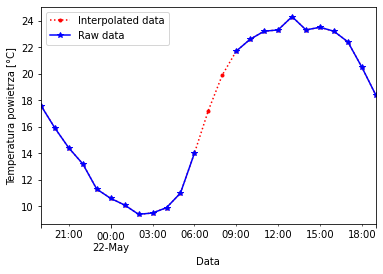

In [43]:
# example of 1st case interpolation - short gaps

m1_time = pd.to_datetime('2016-05-22 07:00:00')

t0 = m1_time - pd.Timedelta(hours=12)
tn = m1_time + pd.Timedelta(hours=12)

m1_raw = df.xs(349210670, level=1)['Temperatura powietrza [°C]']
m1_int = m1_raw.interpolate(method='cubic', limit=2, limit_direction='both')

m1_int.loc[t0:tn].plot(style='.:', color='r', label='Interpolated data', legend=True)
m1_raw.loc[t0:tn].plot(style='*-', color='b', label='Raw data', ylabel='Temperatura powietrza [°C]', legend=True)

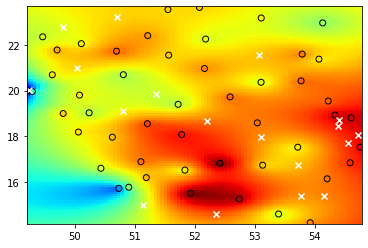

In [44]:
# example of 2nd case interpolation - longer gaps

m2_time = pd.to_datetime('2014-08-28 20:00:00')

m2_m = df.loc[m2_time]['Temperatura powietrza [°C]']

m2 = station_locations.copy()
m2['measure'] = m2_m
m2_na = m2['measure'].isna()

xi, yi = np.meshgrid(np.linspace(m2['Latitude'].min(), m2['Latitude'].max(), 100), 
                     np.linspace(m2['Longitude'].min(), m2['Longitude'].max(), 100))

interp = Rbf(
    m2[~m2['measure'].isna()]['Latitude'], 
    m2[~m2['measure'].isna()]['Longitude'], 
    m2[~m2['measure'].isna()]['measure'], 
    function='linear')
zi = interp(xi, yi)


plt.pcolor(xi, yi, zi, cmap='jet', shading='auto')
plt.scatter(x=m2[~m2_na]['Latitude'], 
            y=m2[~m2_na]['Longitude'], 
            c=m2[~m2_na]['measure'], 
            cmap='jet', edgecolors='k')
plt.scatter(x=m2[m2_na]['Latitude'], 
            y=m2[m2_na]['Longitude'],
            marker='x',
            c='White', edgecolors='k')
plt.show()

### Interpolate short gaps

In [45]:
dfu = df.unstack(level=1)

# precipitation is collected for 6 hours and then reported, so I firstly do backfill interpolation for 5 hours
for m in ['Opad za 6 godzin [mm]', 'Rodzaj opadu za 6 godzin [kod]']:
    dfu[m] = dfu[m].fillna(method='backfill', limit=5)
    dfu[m] = dfu[m].interpolate(method='linear', limit=12, limit_direction='both')

# interpolate cloudiness with linear interpolation
dfu['Zachmurzenie ogólne [oktanty]'] = \
   dfu['Zachmurzenie ogólne [oktanty]'].interpolate(method='linear', limit=2, limit_direction='both')

# other measurements can be interpolated with cubic method
for m in ['Temperatura powietrza [°C]', 'Ciśnienie na pozimie stacji [hPa]', 'Wiatr_S', 'Wiatr_W']:
    dfu[m] = dfu[m].interpolate(method='cubic', limit=2, limit_direction='both')

df = dfu.stack(dropna=False)

### interpolate longer gaps

In [46]:
# Here is my function to apply this 2d interpolation along all columns for each timepoint.
# To speed up the process I'm using np.apply_along_axis. 
# However, I need to rebuild DataFrame structue, so I've to define 3 nested functions

def my_interpolation_2d(data):
    
    def timepoint_interpolation_2d(data_tp):

        def interp_per_column(column):
            from scipy.interpolate import Rbf

            missing = np.isnan(column)
            correct = ~missing

            # no need to interpolate when all entries are correct
            # we do not perform interpolation with less than 3 values
            if not correct.all() and np.sum(correct) >= 3:

                interp = Rbf(x[correct], y[correct], column[correct], function='linear')
                values = interp(x[missing], y[missing])

                column[missing] = values
            return column

        idx = data_tp.index.levels[1]
        x = idx.map(station_locations['Latitude']).values
        y = idx.map(station_locations['Longitude']).values

        return pd.DataFrame(
            np.apply_along_axis(interp_per_column, 0, data_tp), 
            index=idx,
            columns=data_tp.columns)

    date_group = data.groupby(level='Data')
    output = date_group.apply(timepoint_interpolation_2d)

    return output

df = my_interpolation_2d(df)

### correcting interpolation errors

In [47]:
# as wind speed couldn't be interpolated as wind vectors, now I need to restore this value from vectors
df['Prędkość wiatru'] = np.sqrt(df['Wiatr_S']**2 + df['Wiatr_W']**2)

# sometimes cubic interpolation can provide values outside of expected range
# here I'm applying floor of 0 to wind speed, air pressure and precipitation
df['Prędkość wiatru'].clip(lower=0, inplace=True)
df['Ciśnienie na pozimie stacji [hPa]'].clip(lower=0, inplace=True)
df['Opad za 6 godzin [mm]'].clip(lower=0, inplace=True)

# cloudiness should be between 0 and 9
df['Zachmurzenie ogólne [oktanty]'] = df['Zachmurzenie ogólne [oktanty]'].clip(0, 9).round(0)

# precipitation type should be in [0, 5, 6, 7, 8, 9]
df['Rodzaj opadu za 6 godzin [kod]'] = df['Rodzaj opadu za 6 godzin [kod]'].clip(0, 9).round(0)
df.loc[df['Rodzaj opadu za 6 godzin [kod]'] < 5, 'Rodzaj opadu za 6 godzin [kod]'] = 0

# final data preparation

### data categorization

In [48]:
def to_categorical(y):
    y = np.array(y, dtype='int')
    input_shape = y.shape
    y = y.ravel()
    
    n = y.shape[0]
    num_classes = np.max(y)+1
    
    categorical = np.zeros((n, num_classes), dtype=np.int8)
    categorical[np.arange(n), y] = 1
    
    return np.reshape(categorical, input_shape+(num_classes,))

In [49]:
# precipitation type should be converted into one-hot vector, 
# which is vector of zeros and single 1 in index of category
# for example if our categories are [0, 5, 6, 7, 8, 9], 
# then category 8 will be transformed to [0, 0, 0, 0, 1, 0]

# precipitation type as categorical type
codes = ['brak', 'mżawka', 'deszcz', 'śnieg', 'grad', 'burza']
df[['Rodzaj_opadu_'+codes[i] for i in range(6)]] = to_categorical((df['Rodzaj opadu za 6 godzin [kod]'] - 4).clip(0))

# smooth precipitation amount by applying moving average
dfu = df.unstack(level=1)
dfu['Opad za 6 godzin [mm]'] = dfu['Opad za 6 godzin [mm]'].rolling(window=6, center=True, min_periods=1).mean()
df = dfu.stack(dropna=False)

### time feature

In [50]:
# Time of reporting is very important information for model, thus it has to be included
# However, we cannot include just datatime type. Year is not very usefull, the same as day of month. 
# The weather changes with daily and yearly cycles. So I decided to use day of year and hour of the reports.
# But these values must be transformed similary to wind direction.

In [51]:
datetime_index = df.index.get_level_values(0)
df['y_s'] = np.sin((datetime_index.dayofyear-1)*2*np.pi/365)
df['y_c'] = np.cos((datetime_index.dayofyear-1)*2*np.pi/365)
df['h_s'] = np.sin(datetime_index.hour*2*np.pi/24)
df['h_c'] = np.cos(datetime_index.hour*2*np.pi/24)

### final checks

In [52]:
# check if there is any missing/empty/nan value in DataFrame
df.isnull().any().any()

False

In [53]:
df.describe()

,Zachmurzenie ogólne [oktanty],Temperatura powietrza [°C],Ciśnienie na pozimie stacji [hPa],Opad za 6 godzin [mm],Rodzaj opadu za 6 godzin [kod],Wiatr_S,Wiatr_W,Prędkość wiatru,Rodzaj_opadu_brak,Rodzaj_opadu_mżawka,Rodzaj_opadu_deszcz,Rodzaj_opadu_śnieg,Rodzaj_opadu_grad,Rodzaj_opadu_burza,y_s,y_c,h_s,h_c
count,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06,8.766000e+06
mean,5.333507e+00,8.610654e+00,9.878033e+02,4.529856e-01,2.138235e+00,-3.661566e-01,-7.589100e-01,3.413197e+00,6.594013e-01,6.971253e-03,2.374311e-01,9.328770e-02,3.998403e-04,2.508784e-03,-1.885182e-19,6.844627e-04,-4.736423e-17,2.533021e-23
std,2.863033e+00,8.903439e+00,3.965248e+01,1.614090e+00,2.991597e+00,2.858349e+00,3.132659e+00,2.654018e+00,4.739106e-01,8.320249e-02,4.255086e-01,2.908352e-01,1.999201e-02,5.002490e-02,7.068648e-01,7.073484e-01,7.071068e-01,7.071068e-01
min,0.000000e+00,-3.150000e+01,7.593000e+02,0.000000e+00,0.000000e+00,-6.500000e+01,-5.638156e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.999907e-01,-9.999630e-01,-1.000000e+00,-1.000000e+00
25%,3.000000e+00,2.000000e+00,9.847000e+02,0.000000e+00,0.000000e+00,-1.912610e+00,-2.500000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.055836e-01,-7.086267e-01,-7.071068e-01,-7.071068e-01
50%,7.000000e+00,8.400000e+00,9.961000e+02,2.960595e-16,0.000000e+00,-3.472964e-01,-4.694716e-01,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.303538e-03,6.123234e-17,-6.123234e-17
75%,8.000000e+00,1.520000e+01,1.006000e+03,1.000000e-01,6.000000e+00,1.026060e+00,1.026060e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.055836e-01,7.025275e-01,7.071068e-01,7.071068e-01
max,9.000000e+00,3.800000e+01,1.049800e+03,1.400000e+02,9.000000e+00,4.800000e+01,3.800000e+01,6.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999907e-01,1.000000e+00,1.000000e+00,1.000000e+00


In [54]:
df.to_pickle('./processed_data_final.pkl', compression='bz2')
# df.to_pickle('./processed_data_final.pkl')